<a href="https://colab.research.google.com/github/Eiko58/Hippocampus_segmentation/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision

In [9]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import time
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
from scipy.io import loadmat
import nibabel as nib
import csv
#IMAGE PROCESS
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy.ndimage.filters import convolve
from skimage import data, io, filters
import skimage
from skimage.morphology import convex_hull_image, erosion
from IPython import display
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as patches
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#MODEL LAYERS
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape, Conv2DTranspose,\
LeakyReLU, GaussianNoise, GlobalMaxPooling2D, ReLU, Input, Concatenate
#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
!cp -r drive/MyDrive/MRI.zip .

In [ ]:
!unzip MRI.zip

In [13]:
!pwd

/content


In [14]:
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

[PosixPath('.config'),
 PosixPath('drive'),
 PosixPath('label'),
 PosixPath('original'),
 PosixPath('sample_data')]

In [15]:
Label35_Path = Path("label/35label")
Image35_Path = Path("original/35")

In [16]:
Label_Path = list(Label35_Path.glob(r"**/*.jpg"))
Image_Path = list(Image35_Path.glob(r"**/*.jpg"))

In [17]:
print("LABEL LEN:",len(Label_Path))
print("---"*10)
print("IMAGE LEN:",len(Image_Path))

LABEL LEN: 13230
------------------------------
IMAGE LEN: 6615


In [18]:
Label_Series = pd.Series(Label_Path,name="LABEL").astype(str)
Image_Series = pd.Series(Image_Path,name="IMAGE").astype(str)

In [19]:
L_IMG = []
R_IMG = []

Total_IMG = []

Split_Params_For_LABEL = "35label/"
Split_Params_For_IMG = "35/"

Common_Params = "/"

List_Split_Params = "_"


for label_x in Label_Series:
    
    try:
        
        L_Main_Path,L_Target_Path = label_x.split(Split_Params_For_LABEL)
        

        Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
        

        Label_Path_Split = Label_Path_After.split(List_Split_Params)
        


        if Label_Path_Split[-2] == "L":

            L_IMG.append(label_x)
            
            
        elif Label_Path_Split[-2] == "R":
            
            R_IMG.append(label_x)
            
            
        else:
            print("SOMETHING IS WRONG!")
            
    except:
        print("LABEL: ",label_x)
        print("IMG: ",image_x)

Total_IMG = Image_Series.to_list()


In [20]:
len(L_IMG), len(R_IMG), len(Total_IMG)

(6615, 6615, 6615)

In [21]:
print(L_IMG[0])
print(Total_IMG[0])
print(R_IMG[0])

label/35label/ADNI_023_S_0331_25659_ACPC/ADNI_023_S_0331_25659_L/ADNI_023_S_0331_25659_L_023.jpg
original/35/ADNI_023_S_0331_25659_ACPC/ADNI_023_S_0331_25659_ACPC_159.jpg
label/35label/ADNI_023_S_0331_25659_ACPC/ADNI_023_S_0331_25659_R/ADNI_023_S_0331_25659_R_075.jpg


In [22]:
Sort_L = sorted(L_IMG)
Sort_R = sorted(R_IMG)
Sort_IMG = sorted(Total_IMG)

In [23]:
L_IMG = []
R_IMG = []

Total_IMG = []

Split_Params_For_LABEL = "35label/"
Split_Params_For_IMG = "35/"

Common_Params = "/"

for l_img in Sort_L:
  L_Main_Path,L_Target_Path = l_img.split(Split_Params_For_LABEL)
  Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
  check_patient = Label_Path_After[:-10]
  check_picturenr = l_img[-7:-4]
  index = False
  for i in range(len(Sort_IMG)):
    if check_patient in Sort_IMG[i] and check_picturenr == Sort_IMG[i][-7:-4]:
      index = i
  if not index:
    continue
  index_R = False
  for i in range(len(Sort_R)):
    if check_patient in Sort_R[i] and check_picturenr == Sort_R[i][-7:-4]:
      index_R = i
  if not index_R:
    continue
  else:
    L_IMG.append(l_img)
    R_IMG.append(Sort_R[index_R])
    Total_IMG.append(Sort_IMG[index])


In [24]:
len(L_IMG), len(R_IMG), len(Total_IMG)

(6614, 6614, 6614)

In [25]:
Sort_L = sorted(L_IMG)
Sort_R = sorted(R_IMG)
Sort_IMG = sorted(Total_IMG)

In [26]:
te_L = Sort_L
te_R = Sort_R
te_IMG = Sort_IMG

**SAME FOR TRAIN SET (=100)**

In [27]:
Label100_Path = Path("label/100label")
Image100_Path = Path("original/100")
Label_Path = list(Label100_Path.glob(r"**/*.jpg"))
Image_Path = list(Image100_Path.glob(r"**/*.jpg"))

In [28]:
len(Label_Path), len(Image_Path)

(37611, 18900)

In [29]:
Label_Series = pd.Series(Label_Path,name="LABEL").astype(str)
Image_Series = pd.Series(Image_Path,name="IMAGE").astype(str)

In [30]:
Split_Params_For_LABEL = "100label/"
Split_Params_For_IMG = "100/"
Common_Params = "/"
List_Split_Params = "_"

In [31]:
L_IMG = []
R_IMG = []

Total_IMG = []

for label_x in Label_Series:
    
    try:
        
        L_Main_Path,L_Target_Path = label_x.split(Split_Params_For_LABEL)
        
        Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
        

        Label_Path_Split = Label_Path_After.split(List_Split_Params)
        


        if Label_Path_Split[-2] == "L":

            L_IMG.append(label_x)
            
            
        elif Label_Path_Split[-2] == "R":
            
            R_IMG.append(label_x)
            
            
        else:
            print("SOMETHING IS WRONG!")
            
    except:
        print("LABEL: ",label_x)
        

Total_IMG = Image_Series.to_list()

In [32]:
len(L_IMG), len(R_IMG), len(Total_IMG)

(18900, 18711, 18900)

In [33]:
Sort_L = sorted(L_IMG)
Sort_R = sorted(R_IMG)
Sort_IMG = sorted(Total_IMG)

In [34]:
L_IMG = []
R_IMG = []

Total_IMG = []

for l_img in Sort_L:
  L_Main_Path,L_Target_Path = l_img.split(Split_Params_For_LABEL)
  Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
  check_patient = Label_Path_After[:-10]
  check_picturenr = l_img[-7:-4]
  index = False
  for i in range(len(Sort_IMG)):
    if check_patient in Sort_IMG[i] and check_picturenr == Sort_IMG[i][-7:-4]:
      index = i
  if not index:
    continue
  index_R = False
  for i in range(len(Sort_R)):
    if check_patient in Sort_R[i] and check_picturenr == Sort_R[i][-7:-4]:
      index_R = i
  if not index_R:
    continue
  else:
    L_IMG.append(l_img)
    R_IMG.append(Sort_R[index_R])
    Total_IMG.append(Sort_IMG[index])


In [35]:
len(Total_IMG), len(L_IMG), len(R_IMG)

(18710, 18710, 18710)

In [36]:
Sort_L = sorted(L_IMG)
Sort_R = sorted(R_IMG)
Sort_IMG = sorted(Total_IMG)

In [37]:
tr_R = Sort_R
tr_L = Sort_L
tr_IMG = Sort_IMG

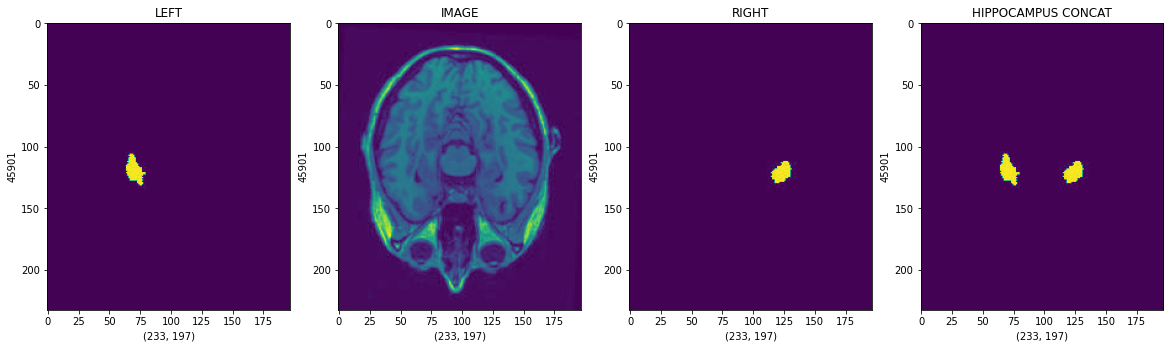

In [38]:
Example_L = cv2.cvtColor(cv2.imread(tr_L[257]), cv2.COLOR_BGR2GRAY)
Example_R = cv2.cvtColor(cv2.imread(tr_R[257]), cv2.COLOR_BGR2GRAY)
Example_IMG = cv2.cvtColor(cv2.imread(tr_IMG[257]), cv2.COLOR_BGR2GRAY)

Hıppocampus_Concat = cv2.addWeighted(Example_L,1,Example_R,1, 0)

figure,axis = plt.subplots(1,4,figsize=(20,20))

axis[0].set_xlabel(Example_L.shape)
axis[0].set_ylabel(Example_L.size)
axis[0].set_title("LEFT")
axis[0].imshow(Example_L)

axis[1].set_xlabel(Example_IMG.shape)
axis[1].set_ylabel(Example_IMG.size)
axis[1].set_title("IMAGE")
axis[1].imshow(Example_IMG)

axis[2].set_xlabel(Example_R.shape)
axis[2].set_ylabel(Example_R.size)
axis[2].set_title("RIGHT")
axis[2].imshow(Example_R)

axis[3].set_xlabel(Hıppocampus_Concat.shape)
axis[3].set_ylabel(Hıppocampus_Concat.size)
axis[3].set_title("HIPPOCAMPUS CONCAT")
axis[3].imshow(Hıppocampus_Concat)


In [39]:
print(Example_L)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [40]:
Hıppocampus_Concat.max(), Hıppocampus_Concat.min()

(255, 1)

In [41]:
list_hip = []
list_IMG = []
path_hip = []
path_IMG = []
split = "/"

for L_IMG, R_IMG, Total_IMG in zip(tr_L, tr_R, tr_IMG):
  Example_L = cv2.cvtColor(cv2.imread(L_IMG),cv2.COLOR_BGR2GRAY)
  Example_R = cv2.cvtColor(cv2.imread(R_IMG),cv2.COLOR_BGR2GRAY)
  Example_IMG = cv2.cvtColor(cv2.imread(Total_IMG),cv2.COLOR_BGR2GRAY)

  Hippocampus_Concat = cv2.addWeighted(Example_L,1,Example_R,1,0)
  list_hip.append(Hippocampus_Concat)
  list_IMG.append(Example_IMG)
   
  path_IMG.append(Total_IMG.split(split)[-1])
  path_hip.append(L_IMG.split(split)[-1].replace('L', 'hip'))

In [42]:
print(path_hip[:3])
print(path_IMG[:3])

['ADNI_002_S_0295_13722_hip_002.jpg', 'ADNI_002_S_0295_13722_hip_003.jpg', 'ADNI_002_S_0295_13722_hip_004.jpg']
['ADNI_002_S_0295_13722_ACPC_002.jpg', 'ADNI_002_S_0295_13722_ACPC_003.jpg', 'ADNI_002_S_0295_13722_ACPC_004.jpg']


In [43]:
np.array(list_hip).shape, np.array(list_IMG).shape, len(path_hip), len(path_IMG)

((18710, 233, 197), (18710, 233, 197), 18710, 18710)

In [44]:
os.chdir('/content')
DIR = 'drive/MyDrive/hippocampus'
#os.mkdir(DIR)
DIR0 = DIR+'/train'
DIR1 = DIR0+'/label'
DIR2 = DIR0+'/Total'
DIR3 = DIR+'/validation'
DIR4 = DIR3+'/label'
DIR5 = DIR3+'/Total'
DIR6 = DIR+'/test'
DIR7 = DIR6+'/label'
DIR8 = DIR6+'/Total'
#os.mkdir(DIR0)
#os.mkdir(DIR1)
#os.mkdir(DIR2)
#os.mkdir(DIR3)
#os.mkdir(DIR4)
#os.mkdir(DIR5)
#os.mkdir(DIR6)
#os.mkdir(DIR7)
#os.mkdir(DIR8)


In [45]:
os.chdir(DIR1)
for i in range(len(path_hip)):
  cv2.imwrite(path_hip[i], list_hip[i])

In [46]:
os.listdir()[:10], len(os.listdir())

(['ADNI_002_S_0295_13722_hip_002.jpg',
  'ADNI_002_S_0295_13722_hip_003.jpg',
  'ADNI_002_S_0295_13722_hip_004.jpg',
  'ADNI_002_S_0295_13722_hip_005.jpg',
  'ADNI_002_S_0295_13722_hip_006.jpg',
  'ADNI_002_S_0295_13722_hip_007.jpg',
  'ADNI_002_S_0295_13722_hip_008.jpg',
  'ADNI_002_S_0295_13722_hip_009.jpg',
  'ADNI_002_S_0295_13722_hip_010.jpg',
  'ADNI_002_S_0295_13722_hip_011.jpg'],
 18710)

In [47]:
os.chdir('/content')
os.chdir(DIR2)
for i in range(len(path_hip)):
  cv2.imwrite(path_IMG[i], list_IMG[i])

In [48]:
!pwd

/content/drive/MyDrive/hippocampus/train/Total


In [49]:
os.listdir()[:10], len(os.listdir())

(['ADNI_002_S_0295_13722_ACPC_002.jpg',
  'ADNI_002_S_0295_13722_ACPC_003.jpg',
  'ADNI_002_S_0295_13722_ACPC_004.jpg',
  'ADNI_002_S_0295_13722_ACPC_005.jpg',
  'ADNI_002_S_0295_13722_ACPC_006.jpg',
  'ADNI_002_S_0295_13722_ACPC_007.jpg',
  'ADNI_002_S_0295_13722_ACPC_008.jpg',
  'ADNI_002_S_0295_13722_ACPC_009.jpg',
  'ADNI_002_S_0295_13722_ACPC_010.jpg',
  'ADNI_002_S_0295_13722_ACPC_011.jpg'],
 18710)

In [50]:
#the same for validation/test data
os.chdir('/content')
list_hip = []
list_IMG = []
path_hip = []
path_IMG = []
split = "/"

for L_IMG, R_IMG, Total_IMG in zip(te_L, te_R, te_IMG):
  Example_L = cv2.cvtColor(cv2.imread(L_IMG),cv2.COLOR_BGR2GRAY)
  Example_R = cv2.cvtColor(cv2.imread(R_IMG),cv2.COLOR_BGR2GRAY)
  Example_IMG = cv2.cvtColor(cv2.imread(Total_IMG),cv2.COLOR_BGR2GRAY)

  Hippocampus_Concat = cv2.addWeighted(Example_L,1,Example_R,1,0)
  list_hip.append(Hippocampus_Concat)
  list_IMG.append(Example_IMG)
   
  path_IMG.append(Total_IMG.split(split)[-1])
  path_hip.append(L_IMG.split(split)[-1].replace('L', 'hip'))

In [51]:
print(np.array(list_hip).shape)
print(np.array(list_IMG).shape)
print(path_hip[:3])
print(path_IMG[:3])

(6614, 233, 197)
(6614, 233, 197)
['ADNI_002_S_0685_18211_hip_002.jpg', 'ADNI_002_S_0685_18211_hip_003.jpg', 'ADNI_002_S_0685_18211_hip_004.jpg']
['ADNI_002_S_0685_18211_tal_noscale_002.jpg', 'ADNI_002_S_0685_18211_tal_noscale_003.jpg', 'ADNI_002_S_0685_18211_tal_noscale_004.jpg']


In [52]:
os.chdir('/content')
os.chdir(DIR7) #test/label
for i in range(3000):
  cv2.imwrite(path_hip[i], list_hip[i])


In [53]:
!pwd

/content/drive/MyDrive/hippocampus/test/label


In [54]:
os.listdir()[:10], len(os.listdir())

(['ADNI_002_S_0685_18211_hip_002.jpg',
  'ADNI_002_S_0685_18211_hip_003.jpg',
  'ADNI_002_S_0685_18211_hip_004.jpg',
  'ADNI_002_S_0685_18211_hip_005.jpg',
  'ADNI_002_S_0685_18211_hip_006.jpg',
  'ADNI_002_S_0685_18211_hip_007.jpg',
  'ADNI_002_S_0685_18211_hip_008.jpg',
  'ADNI_002_S_0685_18211_hip_009.jpg',
  'ADNI_002_S_0685_18211_hip_010.jpg',
  'ADNI_002_S_0685_18211_hip_011.jpg'],
 3000)

In [55]:
os.chdir('/content')
os.chdir(DIR8) #test/Total
for i in range(3000):
  cv2.imwrite(path_IMG[i], list_IMG[i])


In [56]:
!pwd

/content/drive/MyDrive/hippocampus/test/Total


In [57]:
os.listdir()[:10], len(os.listdir())

(['ADNI_002_S_0685_18211_tal_noscale_002.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_003.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_004.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_005.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_006.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_007.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_008.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_009.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_010.jpg',
  'ADNI_002_S_0685_18211_tal_noscale_011.jpg'],
 3000)

In [58]:
os.chdir('/content')
os.chdir(DIR4) #valdiation/label
for i in range(3000, len(path_hip)):
  cv2.imwrite(path_hip[i], list_hip[i])

In [59]:
!pwd

/content/drive/MyDrive/hippocampus/validation/label


In [60]:
os.listdir()[:10], len(os.listdir())

(['ADNI_019_S_4252_300349_hip_167.jpg',
  'ADNI_019_S_4252_300349_hip_168.jpg',
  'ADNI_019_S_4252_300349_hip_169.jpg',
  'ADNI_019_S_4252_300349_hip_170.jpg',
  'ADNI_019_S_4252_300349_hip_171.jpg',
  'ADNI_019_S_4252_300349_hip_172.jpg',
  'ADNI_019_S_4252_300349_hip_173.jpg',
  'ADNI_019_S_4252_300349_hip_174.jpg',
  'ADNI_019_S_4252_300349_hip_175.jpg',
  'ADNI_019_S_4252_300349_hip_176.jpg'],
 3614)

In [61]:
os.chdir('/content')
os.chdir(DIR5) #valdiation/Total
for i in range(3000, len(path_hip)):
  cv2.imwrite(path_IMG[i], list_IMG[i])

In [62]:
!pwd

/content/drive/MyDrive/hippocampus/validation/Total


In [63]:
os.listdir()[:10], len(os.listdir())

(['ADNI_019_S_4252_300349_ACPC_167.jpg',
  'ADNI_019_S_4252_300349_ACPC_168.jpg',
  'ADNI_019_S_4252_300349_ACPC_169.jpg',
  'ADNI_019_S_4252_300349_ACPC_170.jpg',
  'ADNI_019_S_4252_300349_ACPC_171.jpg',
  'ADNI_019_S_4252_300349_ACPC_172.jpg',
  'ADNI_019_S_4252_300349_ACPC_173.jpg',
  'ADNI_019_S_4252_300349_ACPC_174.jpg',
  'ADNI_019_S_4252_300349_ACPC_175.jpg',
  'ADNI_019_S_4252_300349_ACPC_176.jpg'],
 3614)

In [74]:
from torch.utils.data import DataLoader, Dataset
import glob
class img_dataset(Dataset):
    def __init__(self, kind='train'):
        path_kind = 'drive/MyDrive/hippocampus/' + kind
        self.features = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY) for file in glob.glob(path_kind+'/Total/*.jpg')]
        self.targets = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY) for file in glob.glob(path_kind+'/label/*.jpg')]
        assert len(self.features) == len(self.targets), "Something wrong with the dataset"
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        feature, target = self.features[index], self.targets[index]
        feature_tensor = torch.tensor(feature)
        target_tensor = torch.tensor(target)
        return feature_tensor, target_tensor

In [75]:
os.chdir('/content')
abc = img_dataset(kind='train')

In [76]:
print(len(abc))

18710


In [79]:
for x_example, y_example in abc:
    print(x_example, y_example)
    print(x_example.shape)
    print(y_example.shape)
    break

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4]], dtype=torch.uint8) tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.uint8)
torch.Size([233, 197])
torch.Size([233, 197])


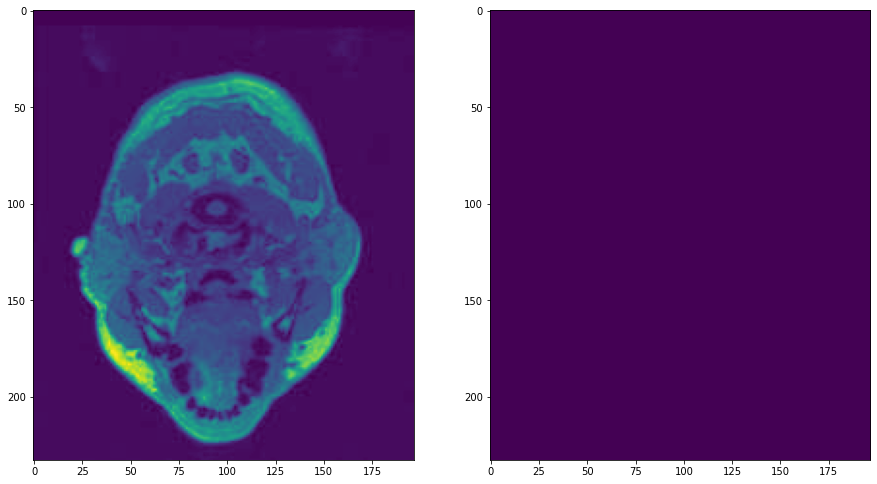

In [86]:
figure,axis = plt.subplots(1,2,figsize=(15,15))
axis[0].imshow(x_example.numpy())
axis[1].imshow(y_example.numpy())

In [88]:
abc_dataloader = DataLoader(abc, batch_size=8, shuffle=True)

torch.Size([8, 233, 197])
torch.Size([8, 233, 197])


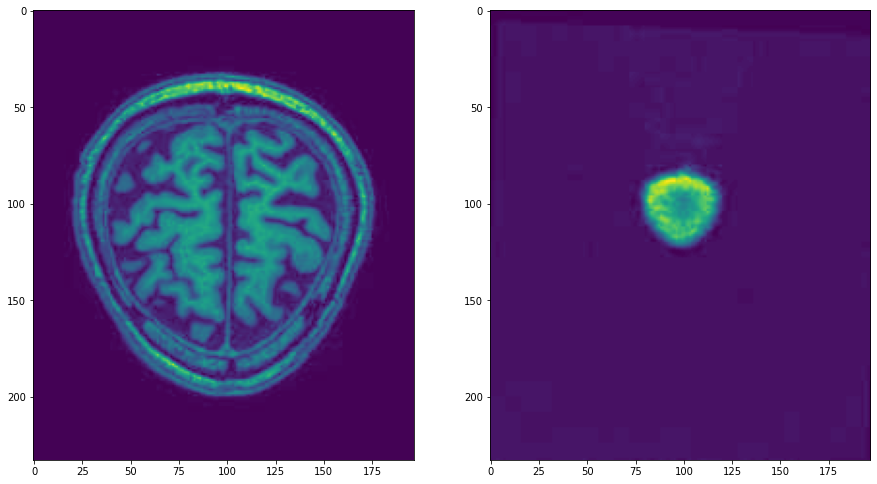

In [89]:
figure,axis = plt.subplots(1,2,figsize=(15,15))
for batch_features, batch_targets in abc_dataloader:
    print(batch_features.shape)
    print(batch_targets.shape)
    axis[0].imshow(batch_features[0].numpy())
    axis[1].imshow(batch_features[1].numpy())
    break